In [1]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("matches_differences.csv")
df["abs_relative_difference"] = abs(df["relative_difference"])
df["copy_in_from"] = df.apply(lambda x: f"{x['copy_in']} -> {x['copy_from']}", axis=1)
df

,activity_name,copy_in,copy_from,copy,original,copy_score,original_score,relative_difference,abs_relative_difference,copy_in_from
0,"Tillage, harrowing, by rotary harrow {CH}| pro...",agribalyse3,ecoinvent_3.8_cutoff_from_sp,"('agribalyse3', 'ad50eff5e9f15fdae85d92967a7ac...","('ecoinvent_3.8_cutoff_from_sp', '73f7653bb2bc...",69.209111,68.320376,0.013008,0.013008,agribalyse3 -> ecoinvent_3.8_cutoff_from_sp
1,Plastic tunnel {GLO}| market for plastic tunne...,agribalyse3,ecoinvent_3.8_cutoff_from_sp,"('agribalyse3', '5ed49451b89bd5ce7474db8241ec9...","('ecoinvent_3.8_cutoff_from_sp', '6d4c2b775e59...",0.836863,0.862578,-0.029811,0.029811,agribalyse3 -> ecoinvent_3.8_cutoff_from_sp
2,"Steel, low-alloyed {RER}| steel production, co...",agribalyse3,ecoinvent_3.8_cutoff_from_sp,"('agribalyse3', '1052369803d78a2d9d8f4a64cd092...","('ecoinvent_3.8_cutoff_from_sp', '824be4a0bb1f...",2.407135,2.158859,0.115003,0.115003,agribalyse3 -> ecoinvent_3.8_cutoff_from_sp
3,"Citric acid {RER}| production | Cut-off, U",agribalyse3,ecoinvent_3.8_cutoff_from_sp,"('agribalyse3', 'e6d38fee85b2232d0333fbcb3b051...","('ecoinvent_3.8_cutoff_from_sp', 'e16eb5a0104b...",2.919859,2.752789,0.060691,0.060691,agribalyse3 -> ecoinvent_3.8_cutoff_from_sp
4,"Waste glass {CH}| treatment of, inert material...",agribalyse3,ecoinvent_3.8_cutoff_from_sp,"('agribalyse3', '198be0c829b50d5d0373afd8d76e7...","('ecoinvent_3.8_cutoff_from_sp', 'dece53f51644...",0.004306,0.004237,0.016213,0.016213,agribalyse3 -> ecoinvent_3.8_cutoff_from_sp
...,...,...,...,...,...,...,...,...,...,...
1953,"Potato grading {GLO}| market for | Cut-off, U",WFLDB,ecoinvent_3.8_cutoff_from_sp,"('WFLDB', '421d24c5d3228f95c3e97ea58db74f8f')","('ecoinvent_3.8_cutoff_from_sp', '08c08f2f301b...",0.002300,0.002189,0.050711,0.050711,WFLDB -> ecoinvent_3.8_cutoff_from_sp
1954,"Orbencarb {GLO}| market for | Cut-off, U",WFLDB,ecoinvent_3.8_cutoff_from_sp,"('WFLDB', '3fef5ea5cd3c543b65cad5feeba8b5cc')","('ecoinvent_3.8_cutoff_from_sp', '0b6fe94cc7f8...",10.038590,10.182498,-0.014133,0.014133,WFLDB -> ecoinvent_3.8_cutoff_from_sp
1955,"Ceramic tile {GLO}| market for | Cut-off, U",WFLDB,ecoinvent_3.8_cutoff_from_sp,"('WFLDB', 'ab55fb6356152fe5aeeb09229127bd5a')","('ecoinvent_3.8_cutoff_from_sp', 'a474d8f8bc9a...",0.831648,0.790676,0.051819,0.051819,WFLDB -> ecoinvent_3.8_cutoff_from_sp
1956,"Chlorothalonil {GLO}| market for | Cut-off, U",WFLDB,ecoinvent_3.8_cutoff_from_sp,"('WFLDB', '5fcf364dc8a793b3f61330474e1bb1f3')","('ecoinvent_3.8_cutoff_from_sp', '83b4401de8d6...",3.985638,4.005849,-0.005045,0.005045,WFLDB -> ecoinvent_3.8_cutoff_from_sp


<AxesSubplot: ylabel='Count'>

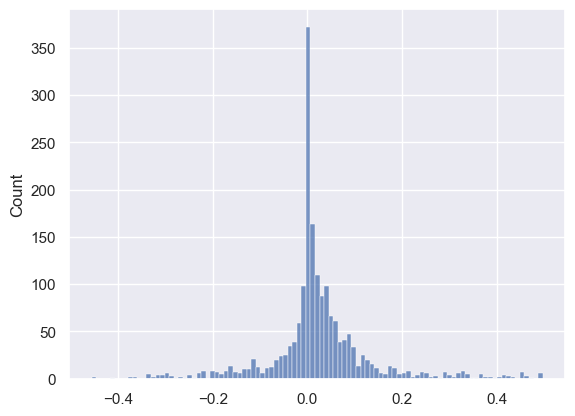

In [2]:
import seaborn as sns

sns.set()

sns.histplot([x for x in df["relative_difference"] if -0.5 < x < 0.5])

(0.0, 1.0)

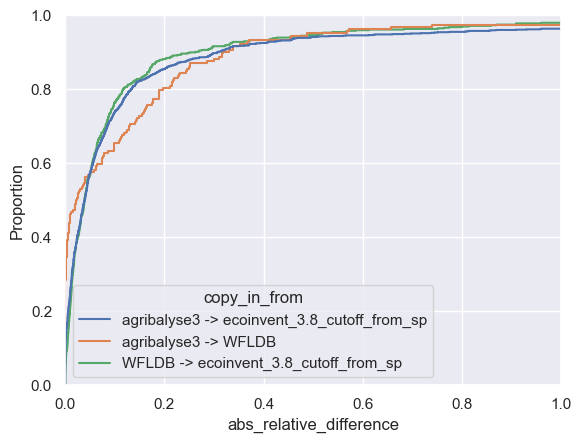

In [3]:
fig, ax = plt.subplots()
sns.ecdfplot(df, x="abs_relative_difference", hue="copy_in_from", ax=ax)
ax.set_xlim(0, 1)

In [4]:
df["relative_difference"].sort_values(key=lambda x: abs(x), ascending=False)

145     1.206187e+09
1470    1.206187e+09
316     5.415643e+02
664     3.126096e+02
424     1.100513e+01
            ...     
828     0.000000e+00
807     0.000000e+00
1500    0.000000e+00
1245    0.000000e+00
1815    0.000000e+00
Name: relative_difference, Length: 1958, dtype: float64

In [5]:
import numpy as np

steps = [0, 0.01, 0.1, 1, 10, np.inf]

for context_str in df["copy_in_from"].unique():
    sub_df = df[df["copy_in_from"] == context_str]
    print(context_str)
    for i in range(len(steps) - 1):
        low, high = steps[i], steps[i + 1]
        print(
            f"{low} < abs_relative_difference < {high} : "
            f"{sum((low < sub_df['abs_relative_difference']) & (sub_df['abs_relative_difference'] < high))}"
        )
    print("\n")

agribalyse3 -> ecoinvent_3.8_cutoff_from_sp
0 < abs_relative_difference < 0.01 : 272
0.01 < abs_relative_difference < 0.1 : 566
0.1 < abs_relative_difference < 1 : 263
1 < abs_relative_difference < 10 : 37
10 < abs_relative_difference < inf : 4


agribalyse3 -> WFLDB
0 < abs_relative_difference < 0.01 : 80
0.01 < abs_relative_difference < 0.1 : 37
0.1 < abs_relative_difference < 1 : 62
1 < abs_relative_difference < 10 : 5
10 < abs_relative_difference < inf : 0


WFLDB -> ecoinvent_3.8_cutoff_from_sp
0 < abs_relative_difference < 0.01 : 118
0.01 < abs_relative_difference < 0.1 : 333
0.1 < abs_relative_difference < 1 : 129
1 < abs_relative_difference < 10 : 9
10 < abs_relative_difference < inf : 1




--------------
### Having a look at a match with a high difference to understand where it comes from.

In [6]:
high_rel_diff = df[(df["abs_relative_difference"] > 1)].sort_values(
    "abs_relative_difference", ascending=False
)
high_rel_diff

,activity_name,copy_in,copy_from,copy,original,copy_score,original_score,relative_difference,abs_relative_difference,copy_in_from
145,Limestone residue {RoW}| market for limestone ...,agribalyse3,ecoinvent_3.8_cutoff_from_sp,"('agribalyse3', 'e7dccdef02192c3b56aab22ba4345...","('ecoinvent_3.8_cutoff_from_sp', '3c63e0103352...",5.404866e-03,4.480950e-12,1.206187e+09,1.206187e+09,agribalyse3 -> ecoinvent_3.8_cutoff_from_sp
1470,Limestone residue {RoW}| market for limestone ...,WFLDB,ecoinvent_3.8_cutoff_from_sp,"('WFLDB', 'e7dccdef02192c3b56aab22ba43458e7')","('ecoinvent_3.8_cutoff_from_sp', '3c63e0103352...",5.404866e-03,4.480950e-12,1.206187e+09,1.206187e+09,WFLDB -> ecoinvent_3.8_cutoff_from_sp
316,"Manure, liquid, cattle {GLO}| manure, liquid, ...",agribalyse3,ecoinvent_3.8_cutoff_from_sp,"('agribalyse3', 'a5af86e0c6d0fa946073496f95f54...","('ecoinvent_3.8_cutoff_from_sp', 'ab85f6fe9f5c...",9.494426e-17,1.749917e-19,5.415643e+02,5.415643e+02,agribalyse3 -> ecoinvent_3.8_cutoff_from_sp
664,"Almond {US}| almond production | Cut-off, U",agribalyse3,ecoinvent_3.8_cutoff_from_sp,"('agribalyse3', '11c6035d3bea1bbc6f1223fb7ea72...","('ecoinvent_3.8_cutoff_from_sp', '01aa9594fa7b...",1.167405e+00,3.722478e-03,3.126096e+02,3.126096e+02,agribalyse3 -> ecoinvent_3.8_cutoff_from_sp
424,"Irrigation {MY}| market for | Cut-off, U",agribalyse3,ecoinvent_3.8_cutoff_from_sp,"('agribalyse3', '8a1531e2c89e4161c021381c0de25...","('ecoinvent_3.8_cutoff_from_sp', 'b660f6dc70e1...",4.033931e-01,3.360173e-02,1.100513e+01,1.100513e+01,agribalyse3 -> ecoinvent_3.8_cutoff_from_sp
1077,"Irrigation {PH}| market for | Cut-off, U",agribalyse3,ecoinvent_3.8_cutoff_from_sp,"('agribalyse3', 'c86350bd7fc242d1c1668457cc74f...","('ecoinvent_3.8_cutoff_from_sp', '3fdf39533ed1...",3.730571e-01,3.593568e-02,9.381244e+00,9.381244e+00,agribalyse3 -> ecoinvent_3.8_cutoff_from_sp
639,"Onion {IN}| onion production | Cut-off, U",agribalyse3,ecoinvent_3.8_cutoff_from_sp,"('agribalyse3', '84bc23ad7d6d4513af614f08203e4...","('ecoinvent_3.8_cutoff_from_sp', 'a5b70ec61904...",5.240420e-01,6.309092e-02,7.306139e+00,7.306139e+00,agribalyse3 -> ecoinvent_3.8_cutoff_from_sp
688,"Irrigation {CN}| market for | Cut-off, U",agribalyse3,ecoinvent_3.8_cutoff_from_sp,"('agribalyse3', 'f54951af37544dec1fb40644a28c0...","('ecoinvent_3.8_cutoff_from_sp', '83ebfaac105b...",4.495037e-01,6.780308e-02,5.629548e+00,5.629548e+00,agribalyse3 -> ecoinvent_3.8_cutoff_from_sp
190,"Irrigation {CA-QC}| market for | Cut-off, U",agribalyse3,ecoinvent_3.8_cutoff_from_sp,"('agribalyse3', '118022c6ce9ebfa48946f062e1dfb...","('ecoinvent_3.8_cutoff_from_sp', '9ec28d5ea759...",3.415408e-01,5.213334e-02,5.551293e+00,5.551293e+00,agribalyse3 -> ecoinvent_3.8_cutoff_from_sp
387,"Irrigation {BR}| market for | Cut-off, U",agribalyse3,ecoinvent_3.8_cutoff_from_sp,"('agribalyse3', 'a7253c8c4cf5c05d745e7343a090d...","('ecoinvent_3.8_cutoff_from_sp', 'b01e408bbab0...",2.629739e-01,4.588318e-02,4.731379e+00,4.731379e+00,agribalyse3 -> ecoinvent_3.8_cutoff_from_sp


In [7]:
import brightway2 as bw

bw.projects.set_current("EF calculation")

match_with_high_difference = high_rel_diff.iloc[3]

original = bw.get_activity(eval(match_with_high_difference["original"]))
copy = bw.get_activity(eval(match_with_high_difference["copy"]))
copy["name"]

'Almond {US}| almond production | Cut-off, S - Copied from Ecoinvent'

Computing inventories for original and copy

In [8]:
method = ("IPCC 2013", "climate change", "GWP 100a")

original_lca = bw.LCA(demand={original: 1}, method=method)
original_lca.lci()
original_lca.lcia()

copy_lca = bw.LCA(demand={copy: 1}, method=method)
copy_lca.lci()
copy_lca.lcia()

In [9]:
original_inventory = (
    original_lca.to_dataframe(cutoff=1000000000).groupby("Flow")["Amount"].sum()
)
original_inventory

Flow
Carbon dioxide, fossil                                -1.674472e+00
Carbon dioxide, from soil or biomass stock             5.939804e-02
Carbon dioxide, to soil or biomass stock               7.129952e-02
Carbon monoxide, fossil                                3.208635e-06
Carbon monoxide, from soil or biomass stock            7.452449e-03
Carbon monoxide, non-fossil                            2.055066e-07
Chloroform                                             9.039080e-07
Dinitrogen monoxide                                    3.333620e-05
Ethane, 1,1,1,2-tetrafluoro-, HFC-134a                 6.484625e-06
Ethane, 1,1,1-trichloro-, HCFC-140                     1.033295e-05
Ethane, 1,1,1-trifluoro-, HFC-143a                     3.282923e-06
Ethane, 1,1,2-trichloro-1,2,2-trifluoro-, CFC-113      7.176186e-06
Ethane, 1,1-difluoro-, HFC-152a                        3.939778e-06
Ethane, 1,2-dichloro-                                  1.611294e-05
Ethane, 1,2-dichloro-1,1,2,2-tetrafluoro-, 

In [10]:
copy_inventory = (
    copy_lca.to_dataframe(cutoff=1000000000).groupby("Flow")["Amount"].sum()
)
copy_inventory

Flow
Carbon dioxide, fossil                                -1.654295e+00
Carbon dioxide, from soil or biomass stock             7.458455e-01
Carbon dioxide, to soil or biomass stock               4.175424e-01
Carbon monoxide, fossil                                9.545261e-07
Carbon monoxide, from soil or biomass stock            4.211692e-01
Carbon monoxide, non-fossil                            3.687926e-07
Chloroform                                             1.095223e-06
Dinitrogen monoxide                                    3.738131e-06
Ethane, 1,1,1,2-tetrafluoro-, HFC-134a                 3.603444e-06
Ethane, 1,1,1-trichloro-, HCFC-140                     5.229076e-06
Ethane, 1,1,2-trichloro-1,2,2-trifluoro-, CFC-113      1.098898e-05
Ethane, 1,1-difluoro-, HFC-152a                        8.331739e-06
Ethane, 1,2-dichloro-                                  1.275581e-05
Ethane, 1,2-dichloro-1,1,2,2-tetrafluoro-, CFC-114     1.503494e-05
Ethane, 2-chloro-1,1,1,2-tetrafluoro-, HCFC

In [11]:
characterization_factors = {cf[0]: cf[1] for cf in bw.Method(method).load()}

Comparing the original and the copy inventories flow by flow

In [26]:
from tqdm.notebook import tqdm

flows_comparison = []
substances = set()
for key, factor in tqdm(characterization_factors.items()):
    flow = bw.get_activity(key)

    # Avoiding to repeat the flows for each compartment as GWP is compartment independent
    if flow["name"] in substances:
        continue
    else:
        substances.add(flow["name"])

    flows_comparison.append(
        {
            "flow": flow["name"],
            "CF": factor,
            "original_impact": original_inventory.get(flow["name"], 0),
            "copy_impact": copy_inventory.get(flow["name"], 0),
            "original_amount": original_inventory.get(flow["name"], 0) / factor,
            "copy_amount": copy_inventory.get(flow["name"], 0) / factor,
        }
    )

flows_comparison = pd.DataFrame(flows_comparison)

  0%|          | 0/211 [00:00<?, ?it/s]

In [27]:
flows_comparison["difference"] = (
    flows_comparison["original_impact"] - flows_comparison["copy_impact"]
)
flows_comparison["relative_difference"] = (
    flows_comparison["difference"] / flows_comparison["original_impact"]
)
flows_comparison = flows_comparison.sort_values("difference")
flows_comparison

,flow,CF,original_impact,copy_impact,original_amount,copy_amount,difference,relative_difference
1,"Carbon dioxide, from soil or biomass stock",1.000000,5.939804e-02,7.458455e-01,5.939804e-02,7.458455e-01,-6.864475e-01,-11.556737
4,"Carbon monoxide, from soil or biomass stock",4.062400,7.452449e-03,4.211692e-01,1.834494e-03,1.036750e-01,-4.137167e-01,-55.514197
2,"Carbon dioxide, to soil or biomass stock",-1.000000,7.129952e-02,4.175424e-01,-7.129952e-02,-4.175424e-01,-3.462429e-01,-4.856174
33,"Methane, from soil or biomass stock",29.700000,3.395127e-03,7.521224e-02,1.143140e-04,2.532399e-03,-7.181711e-02,-21.152998
43,Sulfur hexafluoride,23506.819993,7.574527e-03,6.707499e-02,3.222268e-07,2.853427e-06,-5.950046e-02,-7.855338
22,Methane,29.700000,3.992246e-03,4.119850e-02,1.344191e-04,1.387155e-03,-3.720626e-02,-9.319629
0,"Carbon dioxide, fossil",1.000000,-1.674472e+00,-1.654295e+00,-1.674472e+00,-1.654295e+00,-2.017712e-02,0.012050
37,"Methane, tetrafluoro-, R-14",6625.780421,5.448113e-04,1.906271e-02,8.222599e-08,2.877052e-06,-1.851790e-02,-33.989566
36,"Methane, tetrachloro-, R-10",1728.470681,4.054068e-04,1.516256e-02,2.345466e-07,8.772241e-06,-1.475715e-02,-36.400852
32,"Methane, fossil",29.700000,2.668392e-03,1.320813e-02,8.984485e-05,4.447181e-04,-1.053974e-02,-3.949845
